# Attention is all you need

Adapted from https://colab.research.google.com/github/crazycloud/dl-blog/blob/master/_notebooks/2021_03_18_Transformers_Multihead_Self_Attention_Explanation_%26_Implementation_in_Pytorch.ipynb and http://nlp.seas.harvard.edu/annotated-transformer/

## Preliminaries

In [ ]:
!pip install -q torch
!pip install -q matplotlib

In [ ]:
import math
import copy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())

2.2.1+cu121
True


## Self-attention

$d_E$ - embedding dim: The word embedding dimension and also the dimension for each key, value and query vectors. We assume each word is a $d_E$ dimension vector and we use a Linear Layer to Transform the token vector in to $K, V, Q$ vector of $d_k$ dimension. The reason to transform it into $d_E$ dimension is related to Multiheads where we calculate attention for multiple heads. We will add the multihead after implementing a simple self attention module

$n$ - sequence length: Maximum number of vectors to process at a time

In [ ]:
n = 5 # 5 words sequence length (in practice this would include padding)
d_E = 256 # dimension of word embedding
d_k = 256 # dimension of key/query projection
d_v = d_k # dimension of value projection

In [ ]:
torch.manual_seed(123)

In [ ]:
# generate random sample data
n_B = 10
x = torch.randn(n_B, n, d_E) # (n, d_E)
print(x.shape)

torch.Size([10, 5, 256])


If we consider batch dimension as well the input will be of shape $(n_B, n, d_E)$

Transform input sequence $X$ into [key, query, value] of dimension $d_k$ (assume $d_k = d_v$ for now)
$x \rightarrow q, k, v$

In [ ]:
# projection matrices Q, K, V
# fill in using nn.Linear
query_lin = # TODO
key_lin = # TODO
val_lin = # TODO

q = query_lin(x)
k = key_lin(x)
v = val_lin(x)
# TODO: what is shape of q, k, v?

Now compute attention scores with scalled dot product attention:
$$\mathsf{softmax}_j\left(\frac{(XQ)(XK)^\top}{\sqrt{d_k}}\right)(XV) $$

In [ ]:
def attention(query, key, value):
    "Compute 'Scaled Dot Product Attention'"
    # TODO: fill in, return both the updated vector and the attention scores
    d_k = query.size(-1)
    scores = # TODO
    p_attn = # TODO
    x = # TODO
    return x, p_attn

In [ ]:
x, attn_score = attention(q, k, v)
# TODO: what is shape of x, attn_score?

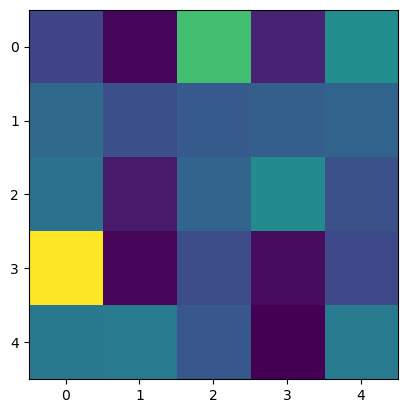

In [ ]:
# try visualizing attending map
plt.imshow(attn_score[0].detach().numpy())

## Multi-head self attention

Multi-head self attention is defined as
$$\mathsf{MultiHead}(X) = [\mathsf{head}_1,\dots,\mathsf{head}_h]W^O$$
where
$$ \mathsf{head}_i = \mathsf{Attention}(XQ_i, XK_i, XV_i)$$

In [ ]:
# simpler version
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v, num_heads):
        super().__init__()
        self.heads = nn.ModuleList(
            [SelfAttention(d_in, d_out_kq, d_out_v)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [ ]:
## some pytorch practice

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None

    def forward(self, query, key, value):
        "Implements Figure 2"
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # QUESTION: what would print(query.shape, key.shape, value.shape) give?
        # what about before the view? i.e. the output of lin(x)?

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value)
        # QUESTION: what would print(x.shape) give?

        # 3) "Concat" using a view
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        # QUESTION: what would print(x.shape) give?
        del query
        del key
        del value

        # apply a final linear
        return self.linears[-1](x)

In [ ]:
d_out = 256
h = 8
mha = MultiHeadedAttention(h, d_out) # what is d_v if d_out = 256 and h = 8?

In [ ]:
x = mha(x, x, x)

NameError: name 'mha' is not defined

# Technical Details of Scaled Dot Product Attention (SPDA)
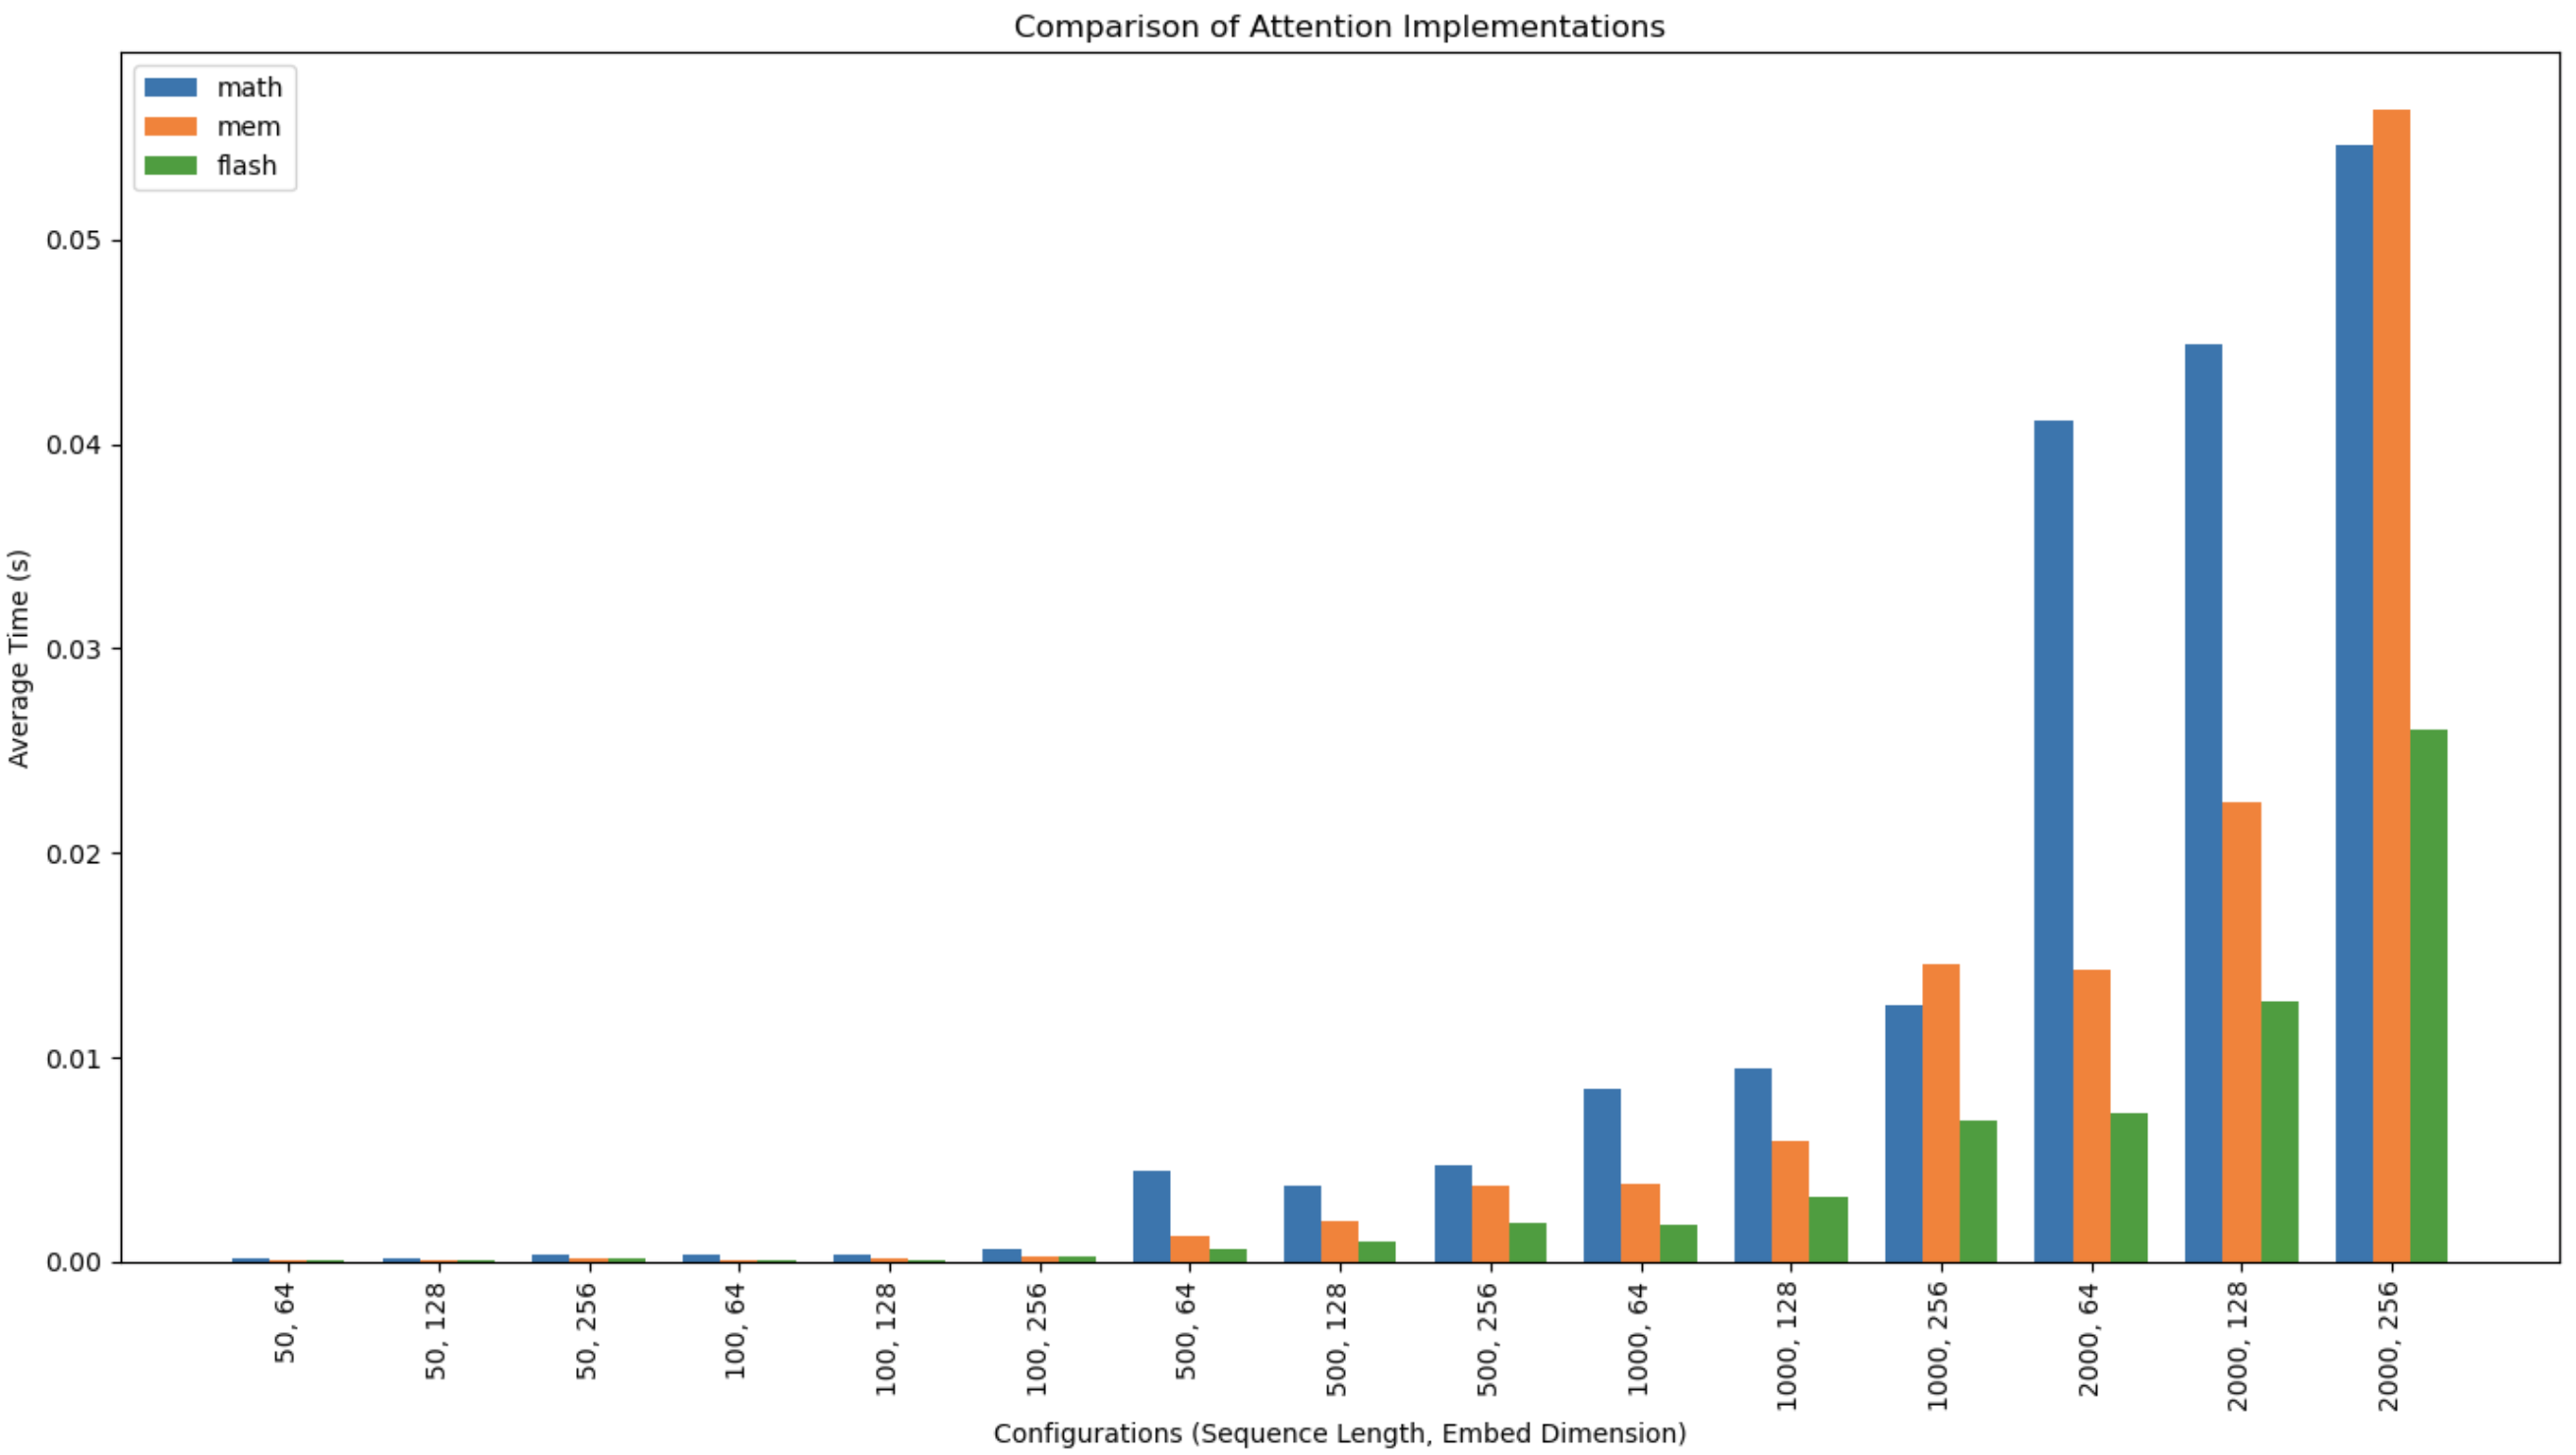

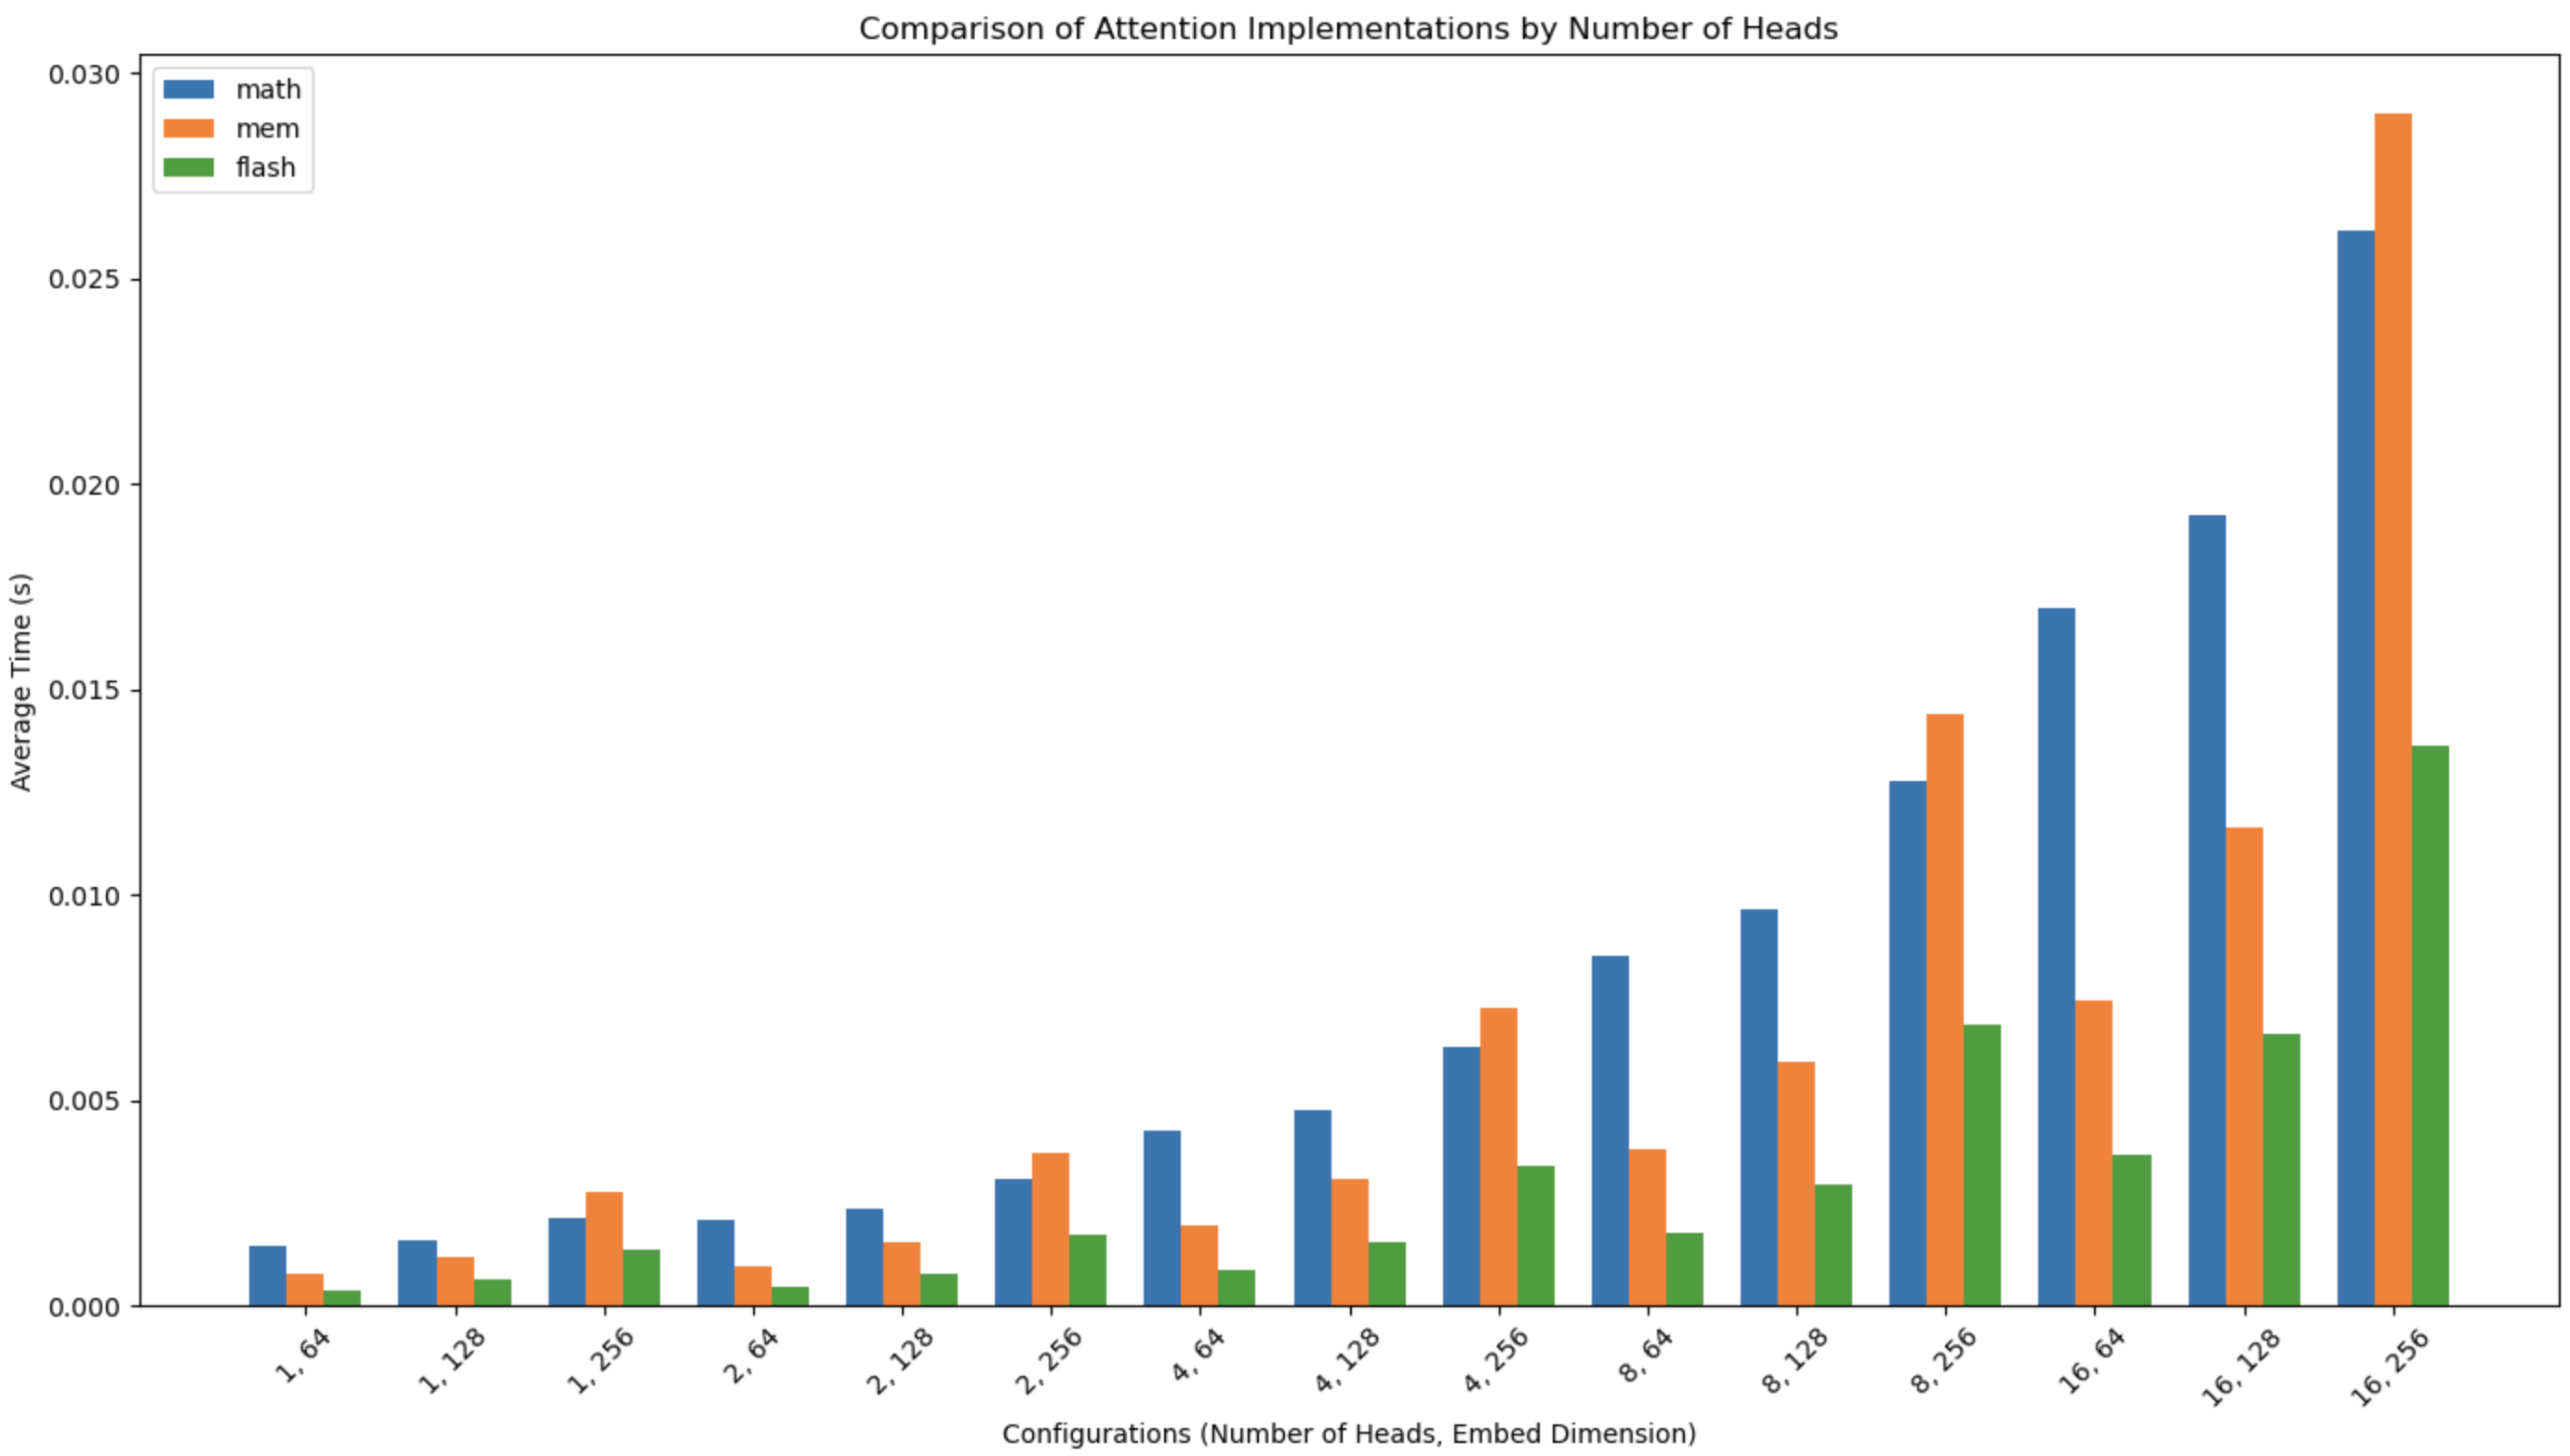

*https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html*

Let's start from the PyTorch official realization of the SPDA (***torch.nn.functional.scaled_dot_product_attention***)




In [ ]:
# Efficient implementation equivalent to the following:
def scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias += attn_mask
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight @ value

As the key component of Transformer, SPDA scales quadratically with respect to the sequence length, there are many ways to optimize this mechanism. There are several built-in options in PyTorch to accelerate:


*   Memory-efficient Attention
*   Flash Attention (2)

Both options are equivalent to the original SDPA. Usually, PyTorch will handle all of those for you. However, you can specify which implementation to use via ***torch.nn.attention.sdpa_kernel()***

In practice, **NEVER writing the SPDA from scratch on yourself if there is no good reason**.


In [ ]:
!nvidia-smi

Mon May 13 18:37:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# use bf16 format for the tensors
torch.set_default_tensor_type(torch.BFloat16Tensor)

def benchmark_attention(seq_length, embed_dim, num_trials=10,num_heads=8, implementation='math'):
    # Set the backend according to the provided implementation flag
    if implementation == 'math':
        torch.backends.cuda.enable_math_sdp(enabled=True)
        torch.backends.cuda.enable_flash_sdp(enabled=False)
        torch.backends.cuda.enable_mem_efficient_sdp(enabled=False)
    elif implementation == 'flash':
        torch.backends.cuda.enable_math_sdp(enabled=False)
        torch.backends.cuda.enable_flash_sdp(enabled=True)
        torch.backends.cuda.enable_mem_efficient_sdp(enabled=False)
    elif implementation == 'mem':
        torch.backends.cuda.enable_math_sdp(enabled=False)
        torch.backends.cuda.enable_flash_sdp(enabled=False)
        torch.backends.cuda.enable_mem_efficient_sdp(enabled=True)
    else:
        print('Invalid implementation specified.')
        return None

    # Initialize random tensors for query, key, value using bf16
    query = torch.randn((128, num_heads,seq_length, embed_dim), device=device)
    key = torch.randn((128, num_heads, seq_length, embed_dim), device=device)
    value = torch.randn((128,num_heads, seq_length, embed_dim), device=device)

    # Warm up GPU
    for _ in range(10):
        _ = F.scaled_dot_product_attention(query, key, value)

    # Timing the attention function
    torch.cuda.synchronize()
    start_time = time.time()
    for _ in range(num_trials):
        _ = F.scaled_dot_product_attention(query, key, value)
    torch.cuda.synchronize()  # Ensure CUDA operations are finished
    avg_time = (time.time() - start_time) / num_trials

    return avg_time

# Example benchmarks
lengths = [50, 100, 500, 1000, 2000]  # Different sequence lengths
dims = [64, 128, 256]  # Different embedding dimensions
implementations = ['math', 'mem','flash']
results = {imp: {} for imp in implementations}

# Run benchmark for each combination of sequence length, dimension, and implementation
for length in lengths:
    for dim in dims:
        for imp in implementations:
            avg_time = benchmark_attention(length, dim, num_trials=3, implementation=imp)
            results[imp].setdefault((length, dim), avg_time)

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(lengths) * len(dims))

for i, imp in enumerate(implementations):
    times = [results[imp][(length, dim)] for length in lengths for dim in dims]
    plt.bar(index + i * bar_width, times, bar_width, label=f'{imp}')

ax.set_xlabel('Configurations (Sequence Length, Embed Dimension)')
ax.set_ylabel('Average Time (s)')
ax.set_title('Comparison of Attention Implementations')
ax.set_xticks(index + bar_width)
ax.set_xticklabels([f'{length}, {dim}' for length in lengths for dim in dims], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use bf16 format for the tensors
torch.set_default_tensor_type(torch.BFloat16Tensor)

def benchmark_attention(embed_dim, num_trials=10, num_heads=8, implementation='math'):
    seq_length = 1000  # Fixed sequence length
    # Set the backend according to the provided implementation flag
    if implementation == 'math':
        torch.backends.cuda.enable_math_sdp(enabled=True)
        torch.backends.cuda.enable_flash_sdp(enabled=False)
        torch.backends.cuda.enable_mem_efficient_sdp(enabled=False)
    elif implementation == 'flash':
        torch.backends.cuda.enable_math_sdp(enabled=False)
        torch.backends.cuda.enable_flash_sdp(enabled=True)
        torch.backends.cuda.enable_mem_efficient_sdp(enabled=False)
    elif implementation == 'mem':
        torch.backends.cuda.enable_math_sdp(enabled=False)
        torch.backends.cuda.enable_flash_sdp(enabled=False)
        torch.backends.cuda.enable_mem_efficient_sdp(enabled=True)
    else:
        print('Invalid implementation specified.')
        return None

    # Initialize random tensors for query, key, value using bf16
    query = torch.randn((128, num_heads, seq_length, embed_dim), device=device)
    key = torch.randn((128, num_heads, seq_length, embed_dim), device=device)
    value = torch.randn((128, num_heads, seq_length, embed_dim), device=device)

    # Warm up GPU
    for _ in range(10):
        _ = F.scaled_dot_product_attention(query, key, value)

    # Timing the attention function
    torch.cuda.synchronize()
    start_time = time.time()
    for _ in range(num_trials):
        _ = F.scaled_dot_product_attention(query, key, value)
    torch.cuda.synchronize()  # Ensure CUDA operations are finished
    avg_time = (time.time() - start_time) / num_trials

    return avg_time

# Different numbers of heads
head_counts = [1, 2, 4, 8, 16]
dims = [64, 128, 256]  # Different embedding dimensions
implementations = ['math', 'mem', 'flash']
results = {imp: {} for imp in implementations}

# Run benchmark for each combination of head count, dimension, and implementation
for num_heads in head_counts:
    for dim in dims:
        for imp in implementations:
            avg_time = benchmark_attention(dim, num_trials=3, num_heads=num_heads, implementation=imp)
            results[imp].setdefault((num_heads, dim), avg_time)

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(head_counts) * len(dims))

for i, imp in enumerate(implementations):
    times = [results[imp][(num_heads, dim)] for num_heads in head_counts for dim in dims]
    plt.bar(index + i * bar_width, times, bar_width, label=f'{imp}')

ax.set_xlabel('Configurations (Number of Heads, Embed Dimension)')
ax.set_ylabel('Average Time (s)')
ax.set_title('Comparison of Attention Implementations by Number of Heads')
ax.set_xticks(index + bar_width / 2 * (len(implementations) - 1))
ax.set_xticklabels([f'{num_heads}, {dim}' for num_heads in head_counts for dim in dims], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()